<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Multivariate time series Rossmann

---


In [2]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import ccf

#### Get the data

Our aim is to study the multivariate time series of customer and sales data

In [4]:
df = pd.read_csv('../../../../resource-datasets/rossmann_stores/rossmann.csv')
# Set the DateTime index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


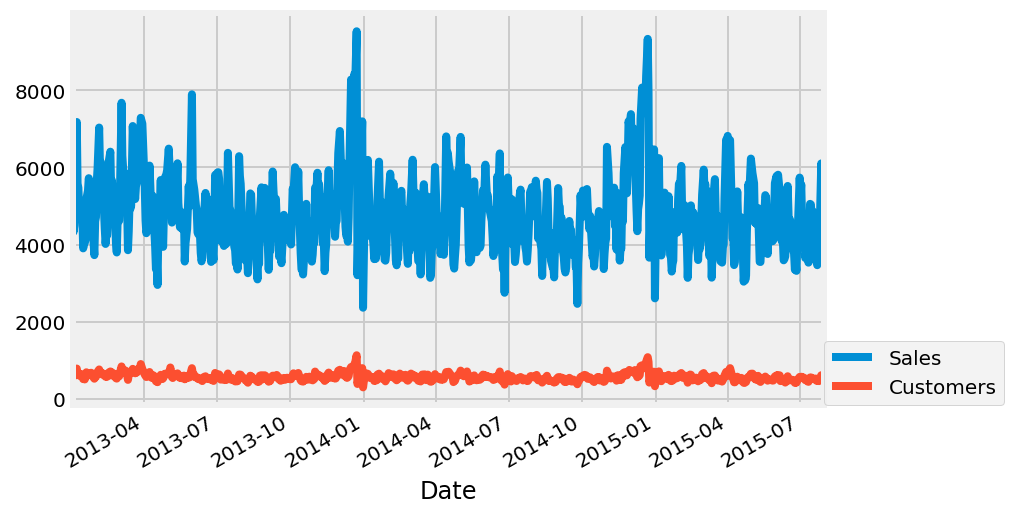

In [5]:
# Filter to Store 1
store1_data = df[df.Store == 1]

# Filter to open days
data = store1_data[store1_data.Open==1].sort_values(by='Date')
data = pd.get_dummies(data, columns=['DayOfWeek','StateHoliday'])
# Plot sales for Store 1 (all days) over time
data[['Sales','Customers']].plot()
plt.legend(loc=[1,0])
plt.show()

#### Use differencing to make the time series stationary.

In [10]:
data_cs = data[["Sales","Customers"]]

In [11]:
data_cs.head()

,Sales,Customers
Date,,
2013-01-02,5530,668
2013-01-03,4327,578
2013-01-04,4486,619
2013-01-05,4997,635
2013-01-07,7176,785


In [12]:
data_cs.tail()

,Sales,Customers
Date,,
2015-07-27,6102,612
2015-07-28,5011,560
2015-07-29,4782,523
2015-07-30,5020,546
2015-07-31,5263,555


#### Visualise the time series.

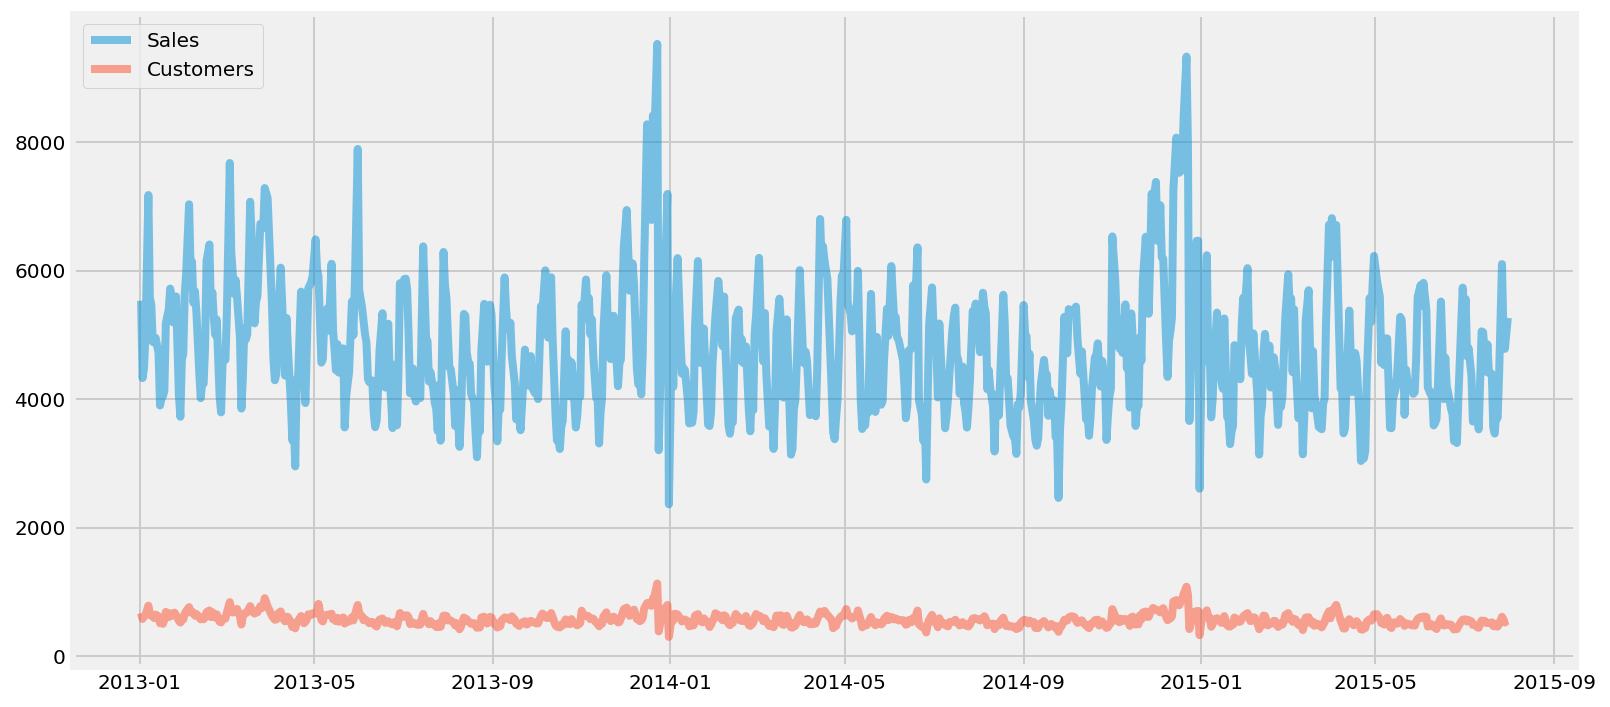

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(data_cs, alpha=0.5)
plt.legend([
            data_cs.columns[0],
            data_cs.columns[1]], loc='upper left')
plt.show()


In [15]:
data_cs_diff = data_cs.diff()

In [25]:
data_cs_diff = data_cs_diff[1:]

In [26]:
data_cs_diff.head()

,Sales,Customers
Date,,
2013-01-03,-1203.0,-90.0
2013-01-04,159.0,41.0
2013-01-05,511.0,16.0
2013-01-07,2179.0,150.0
2013-01-08,-1596.0,-131.0


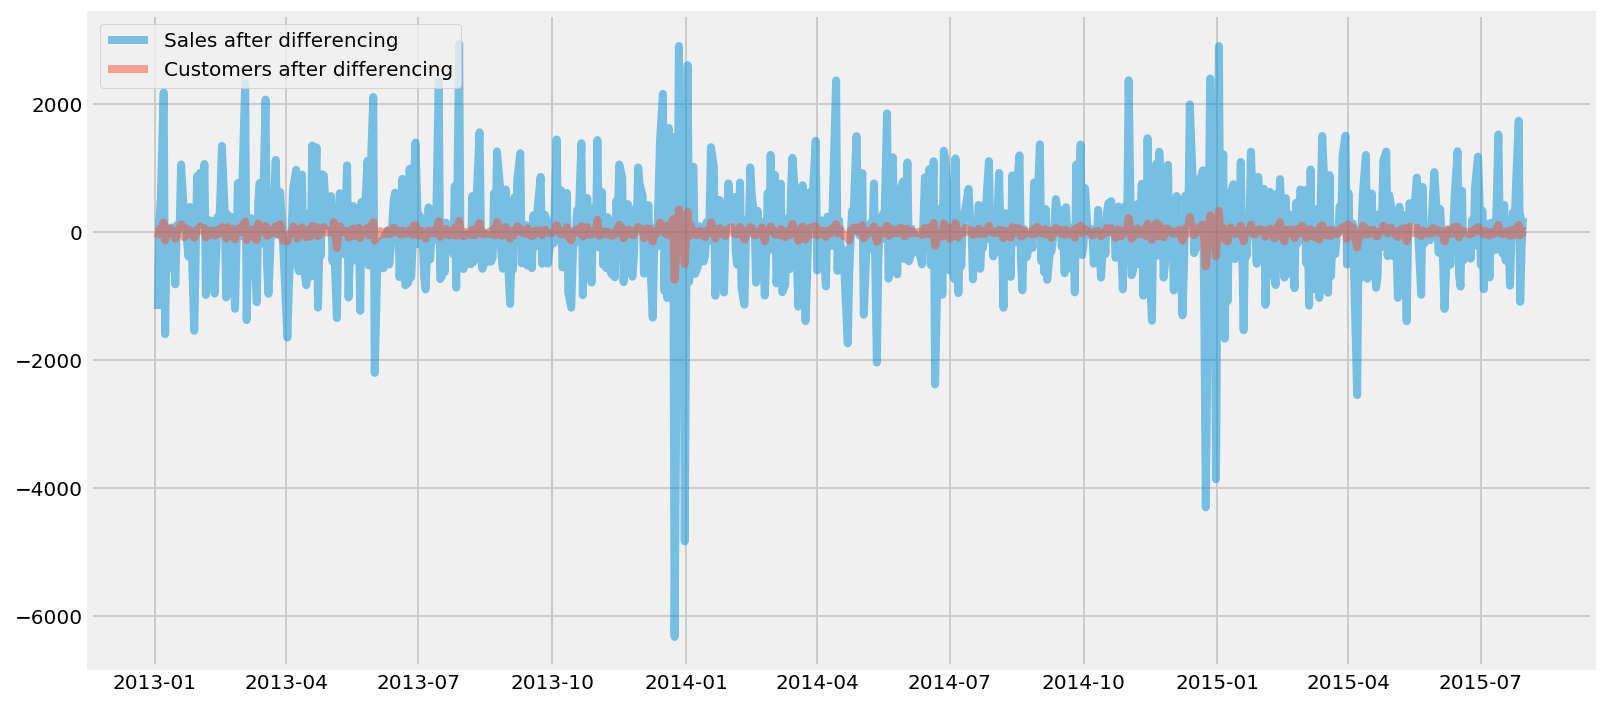

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(data_cs_diff, alpha=0.5)
plt.legend([
            data_cs_diff.columns[0]+' after differencing',
            data_cs_diff.columns[1]+' after differencing'], loc='upper left')
plt.show()


Look at the values of the cross correlation matrix at every lag for each pair of variables.

In [28]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

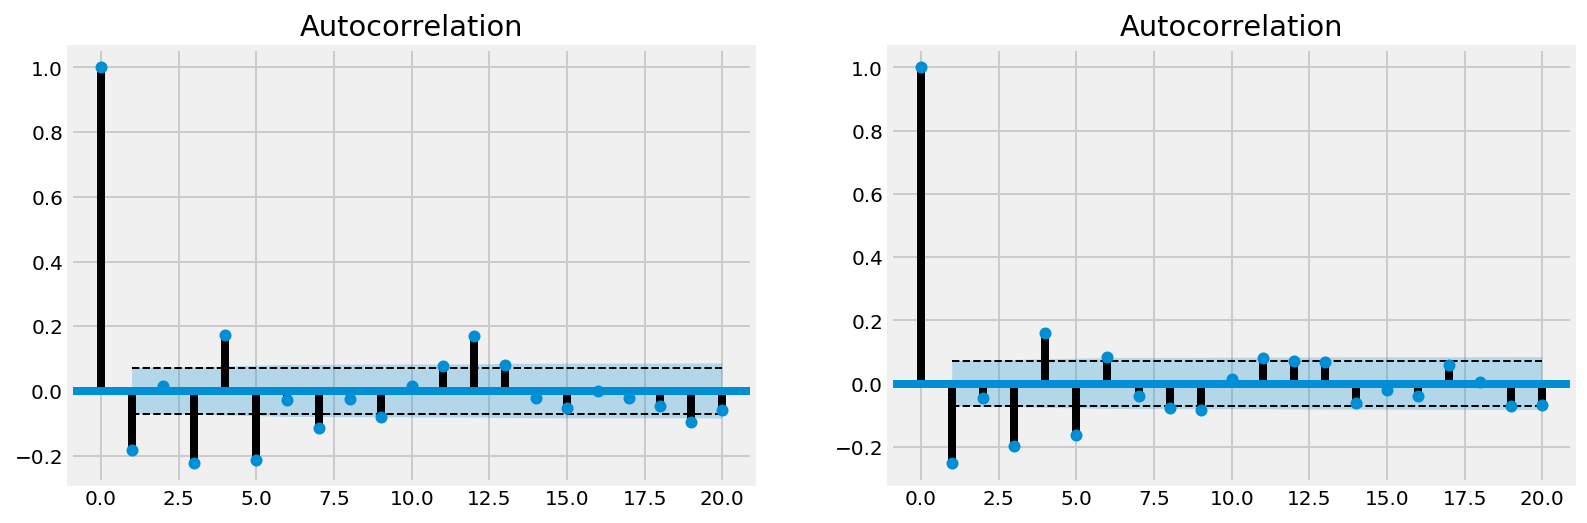

In [29]:
alpha = 0.05
se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(data_cs_diff))
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
plot_acf(data_cs_diff.Sales, lags=20, ax=ax[0])
ax[0].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
plot_acf(data_cs_diff.Customers, lags=20, ax=ax[1])
ax[1].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
plt.show()


# 说明二者相互关联较强，且图一11-13的部分显示出一点seasonality

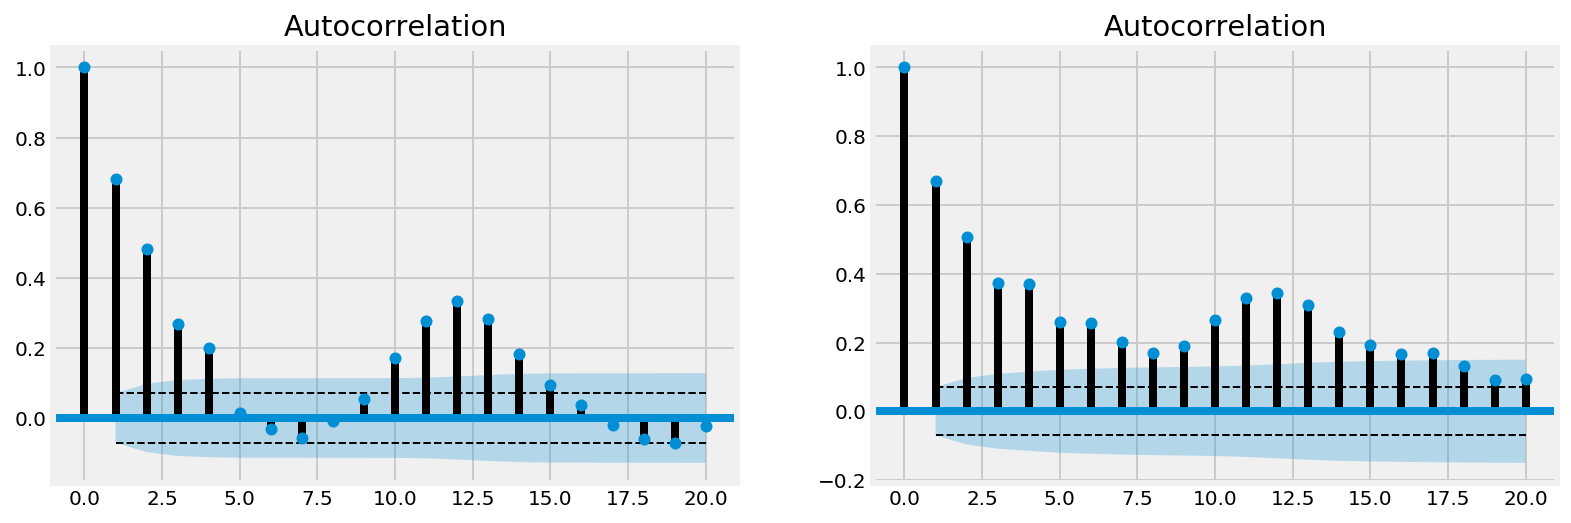

In [30]:
alpha = 0.05
se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(data_cs))
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
plot_acf(data_cs.Sales, lags=20, ax=ax[0])
ax[0].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
plot_acf(data_cs.Customers, lags=20, ax=ax[1])
ax[1].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
plt.show()

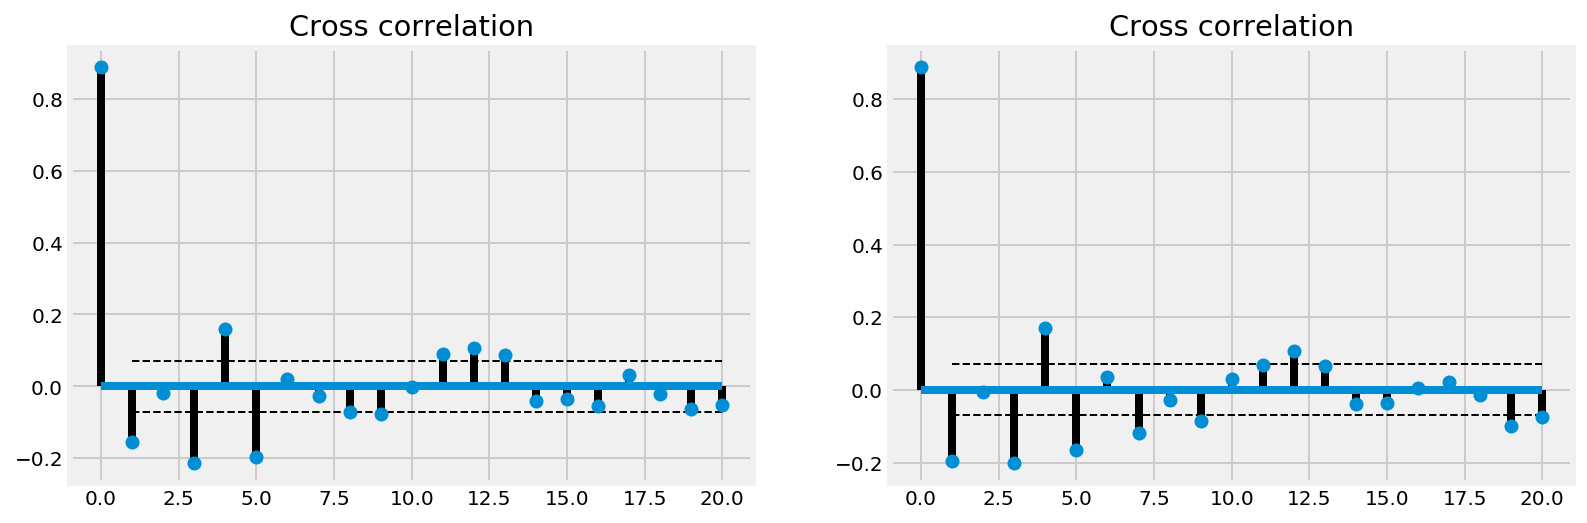

In [31]:
ccf_Sales_Customers = ccf(data_cs_diff.Sales, data_cs_diff.Customers)
ccf_Customers_Sales = ccf(data_cs_diff.Customers, data_cs_diff.Sales)
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].stem(ccf_Sales_Customers[:21], use_line_collection=True, linefmt='k', basefmt='')
ax[0].set_title('Cross correlation')
ax[0].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
ax[1].stem(ccf_Customers_Sales[:21], use_line_collection=True, linefmt='k', basefmt='')
ax[1].set_title('Cross correlation')
ax[1].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
plt.show()


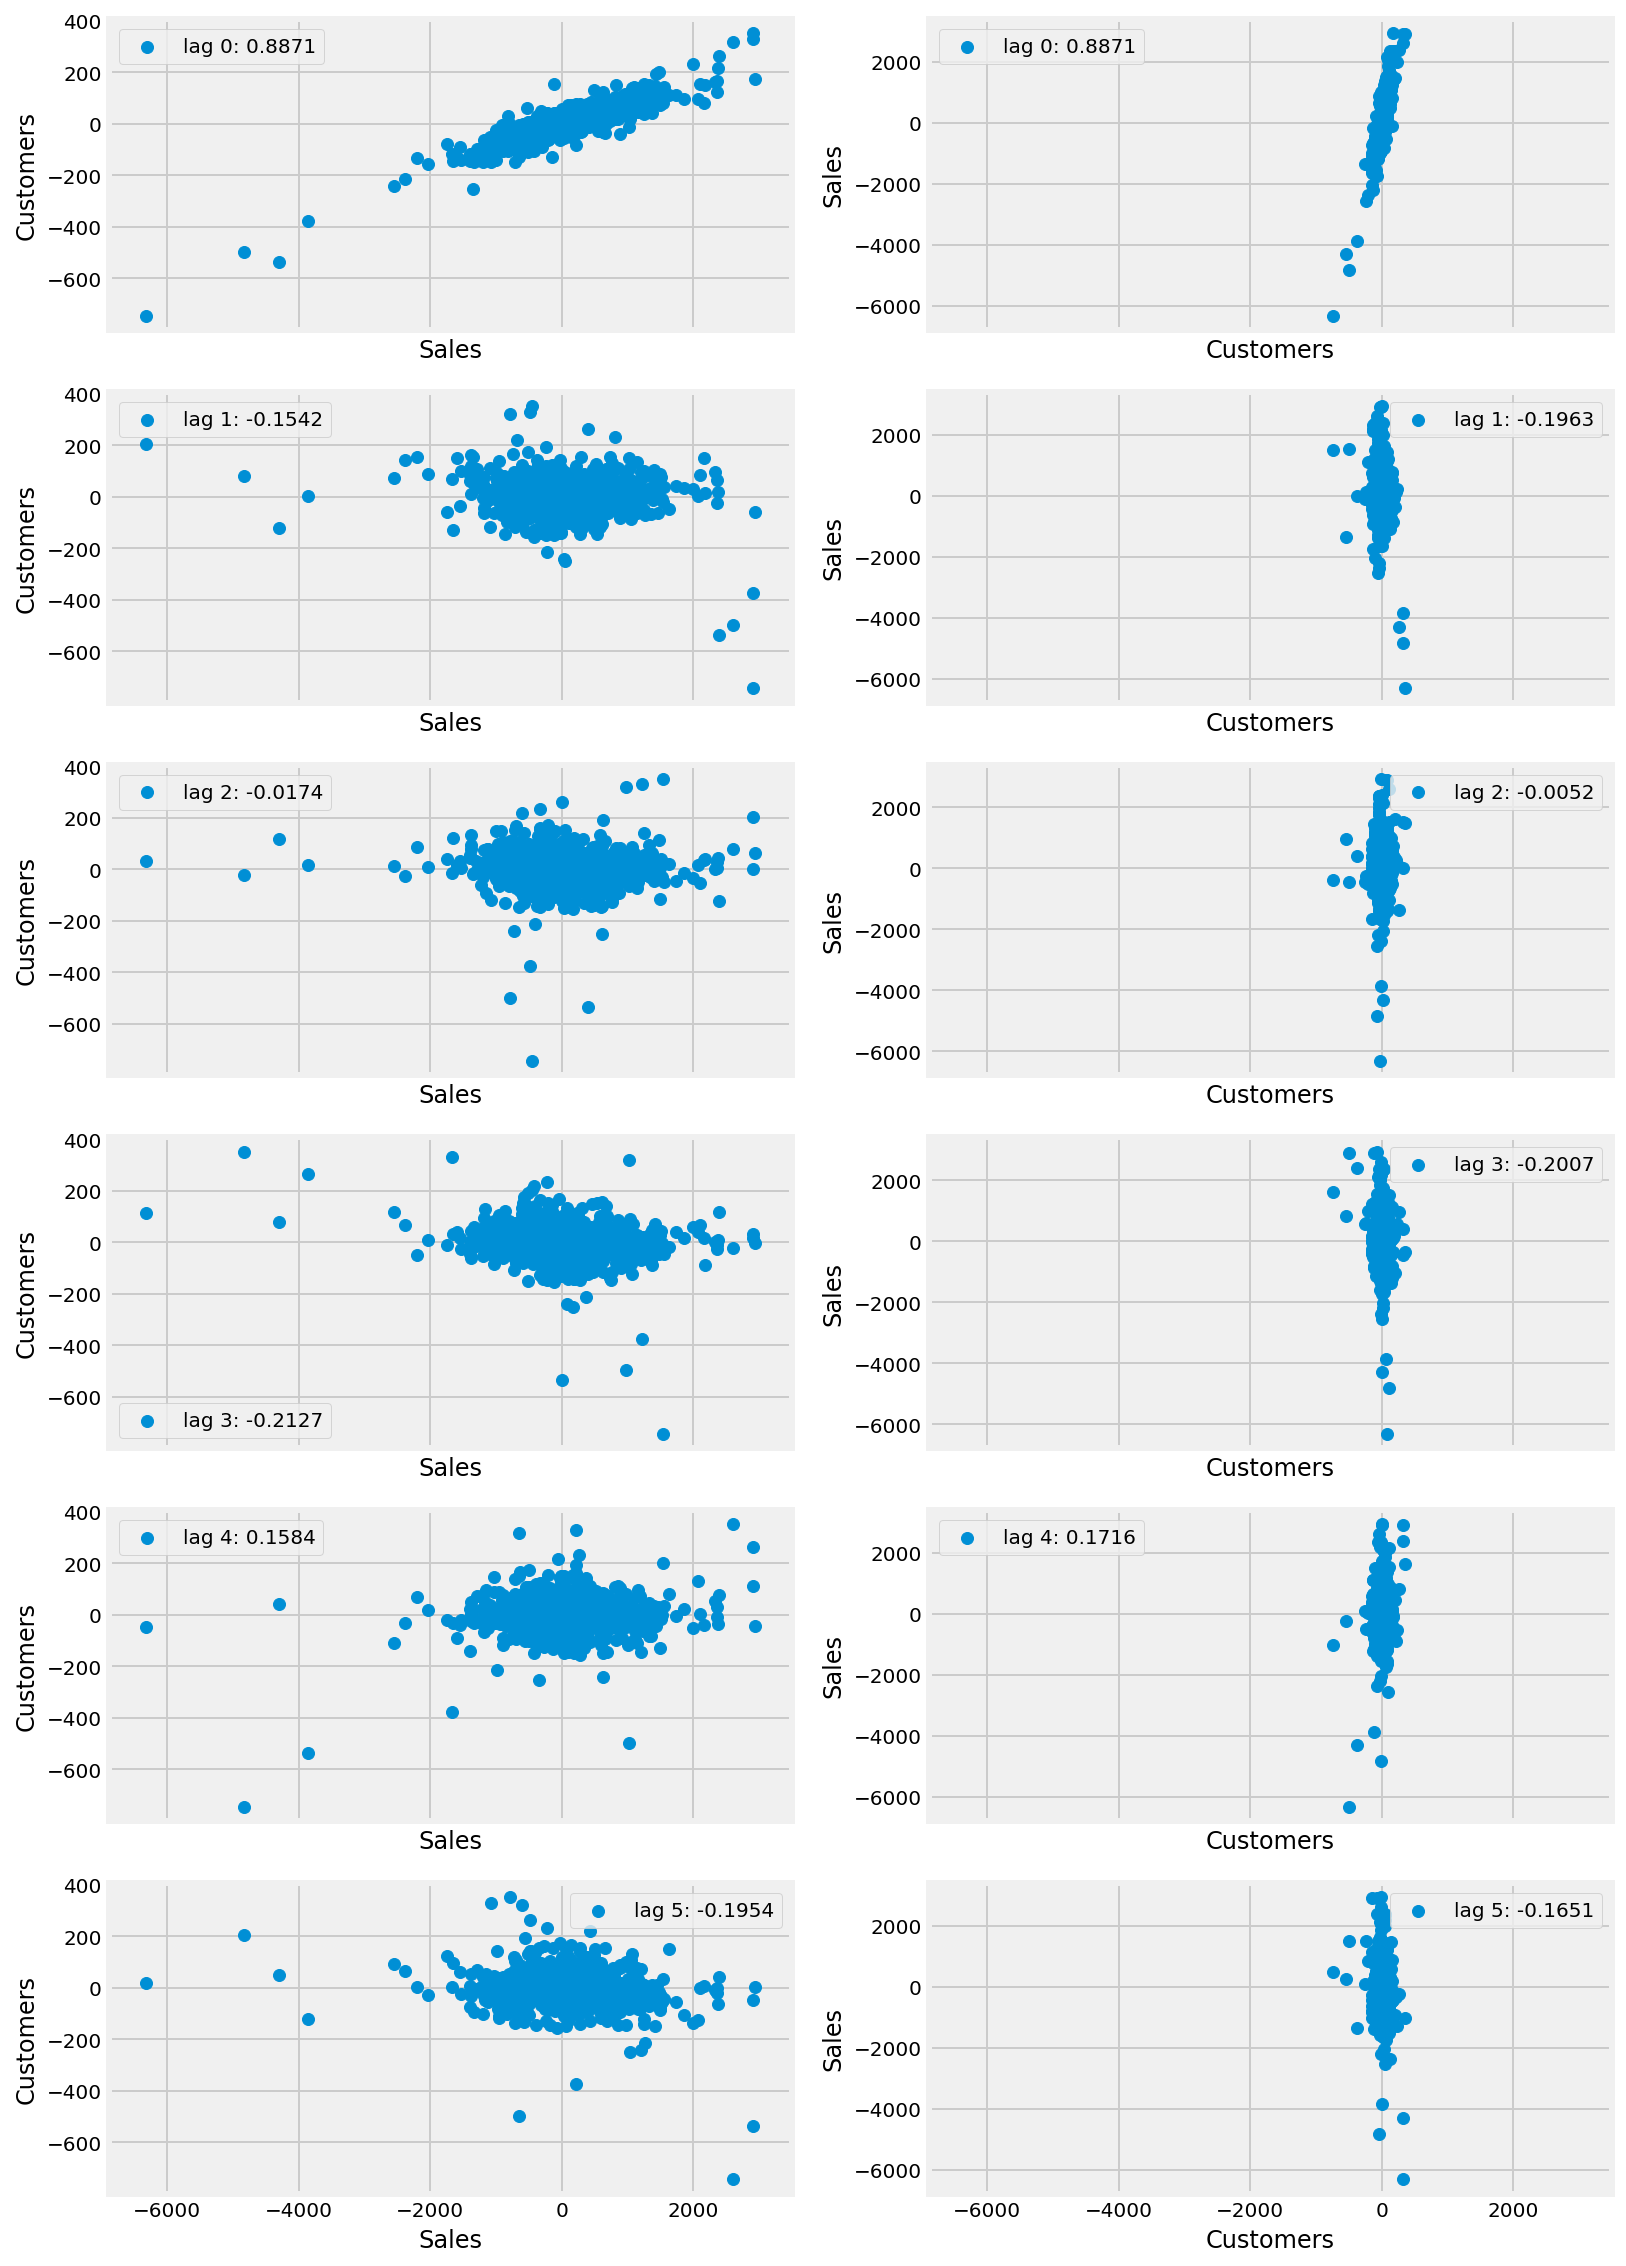

In [33]:
ig, ax = plt.subplots(nrows=6, ncols=2, sharex=True, figsize=(12, 20))
for i in range(0, ax.shape[0]):
    
    ax[i][0].scatter(data_cs_diff.iloc[i:]['Sales'], data_cs_diff['Customers'].shift(i).dropna(), 
                    label=f'lag {i}: {round(ccf_Sales_Customers[i], 4)}')
    ax[i][0].set_xlabel('Sales')
    ax[i][0].set_ylabel('Customers')
    ax[i][0].legend()
    
    ax[i][1].scatter(data_cs_diff.iloc[i:]['Customers'], data_cs_diff['Sales'].shift(i).dropna(), 
                    label=f'lag {i}: {round(ccf_Customers_Sales[i], 4)}')
    ax[i][1].set_ylabel('Sales')
    ax[i][1].set_xlabel('Customers')
    ax[i][1].legend()
plt.show()


#### Fit different VARMA models. 

In [35]:
model = sm.tsa.VARMAX(data_cs_diff, order=(1,1), trend="c")
results= model.fit(maxiter=1000, disp=False)
results.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Dep. Variable:,"['Sales', 'Customers']",No. Observations:,780
Model:,"VARMA(1,1)",Log Likelihood,-10042.429
,+ intercept,AIC,20110.858
Date:,"Tue, 20 Aug 2019",BIC,20171.429
Time:,15:39:12,HQIC,20134.155
Sample:,0,,
,- 780,,
Covariance Type:,opg,,
Ljung-Box (Q):,"256.19, 62.04",Jarque-Bera (JB):,"1887.46, 170.43"
Prob(Q):,"0.00, 0.01",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"1.20, 1.06",Skew:,"-0.75, 0.27"


#### Extract the AR and MA coefficient matrices.

In [36]:
print(results.coefficient_matrices_var)

[[[-0.23037135 -0.51983317]
  [-0.0260526   0.19190187]]]


In [37]:
print(results.coefficient_matrices_vma)

[[[ 0.14589339 -0.21881764]
  [ 0.07509536 -0.93923126]]]


#### Search for the best AR model according to AIC and BIC.

In [46]:
model = sm.tsa.VARMAX(data_cs_diff, order=(2,3), trend="c")
results= model.fit(maxiter=1000, disp=False)
results.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Dep. Variable:,"['Sales', 'Customers']",No. Observations:,780
Model:,"VARMA(2,3)",Log Likelihood,-9934.632
,+ intercept,AIC,19919.264
Date:,"Tue, 20 Aug 2019",BIC,20035.746
Time:,15:51:05,HQIC,19964.065
Sample:,0,,
,- 780,,
Covariance Type:,opg,,
Ljung-Box (Q):,"179.80, 48.39",Jarque-Bera (JB):,"692.18, 173.91"
Prob(Q):,"0.00, 0.17",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"1.18, 1.05",Skew:,"-0.22, 0.16"


In [47]:
for i in range(1, 6):
    model = sm.tsa.VARMAX(data_cs_diff, order=(i, 0))
    results = model.fit(maxiter=1000, disp=False)
    print(i, results.aic, results.bic)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 20274.480228598062 20316.413873875215


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 20216.20360555438 20276.774426510266


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3 20124.164207436097 20203.372204070718


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4 20102.94073150446 20200.785903817814


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5 20023.83430795258 20140.316655944673


In [48]:
for i in range(1, 6):
    model = sm.tsa.VARMAX(data_cs_diff, order=(0, i))
    results = model.fit(maxiter=1000, disp=False)
    print(i, results.aic, results.bic)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 20112.769193510903 20154.702838788056


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 20068.429318609047 20129.000139564934


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3 19996.41166114666 20075.61965778128


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4 20027.538906121685 20125.38407843504


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5 19935.775901192585 20052.258249184677


#### Look at the best model

#### Plot the residuals 

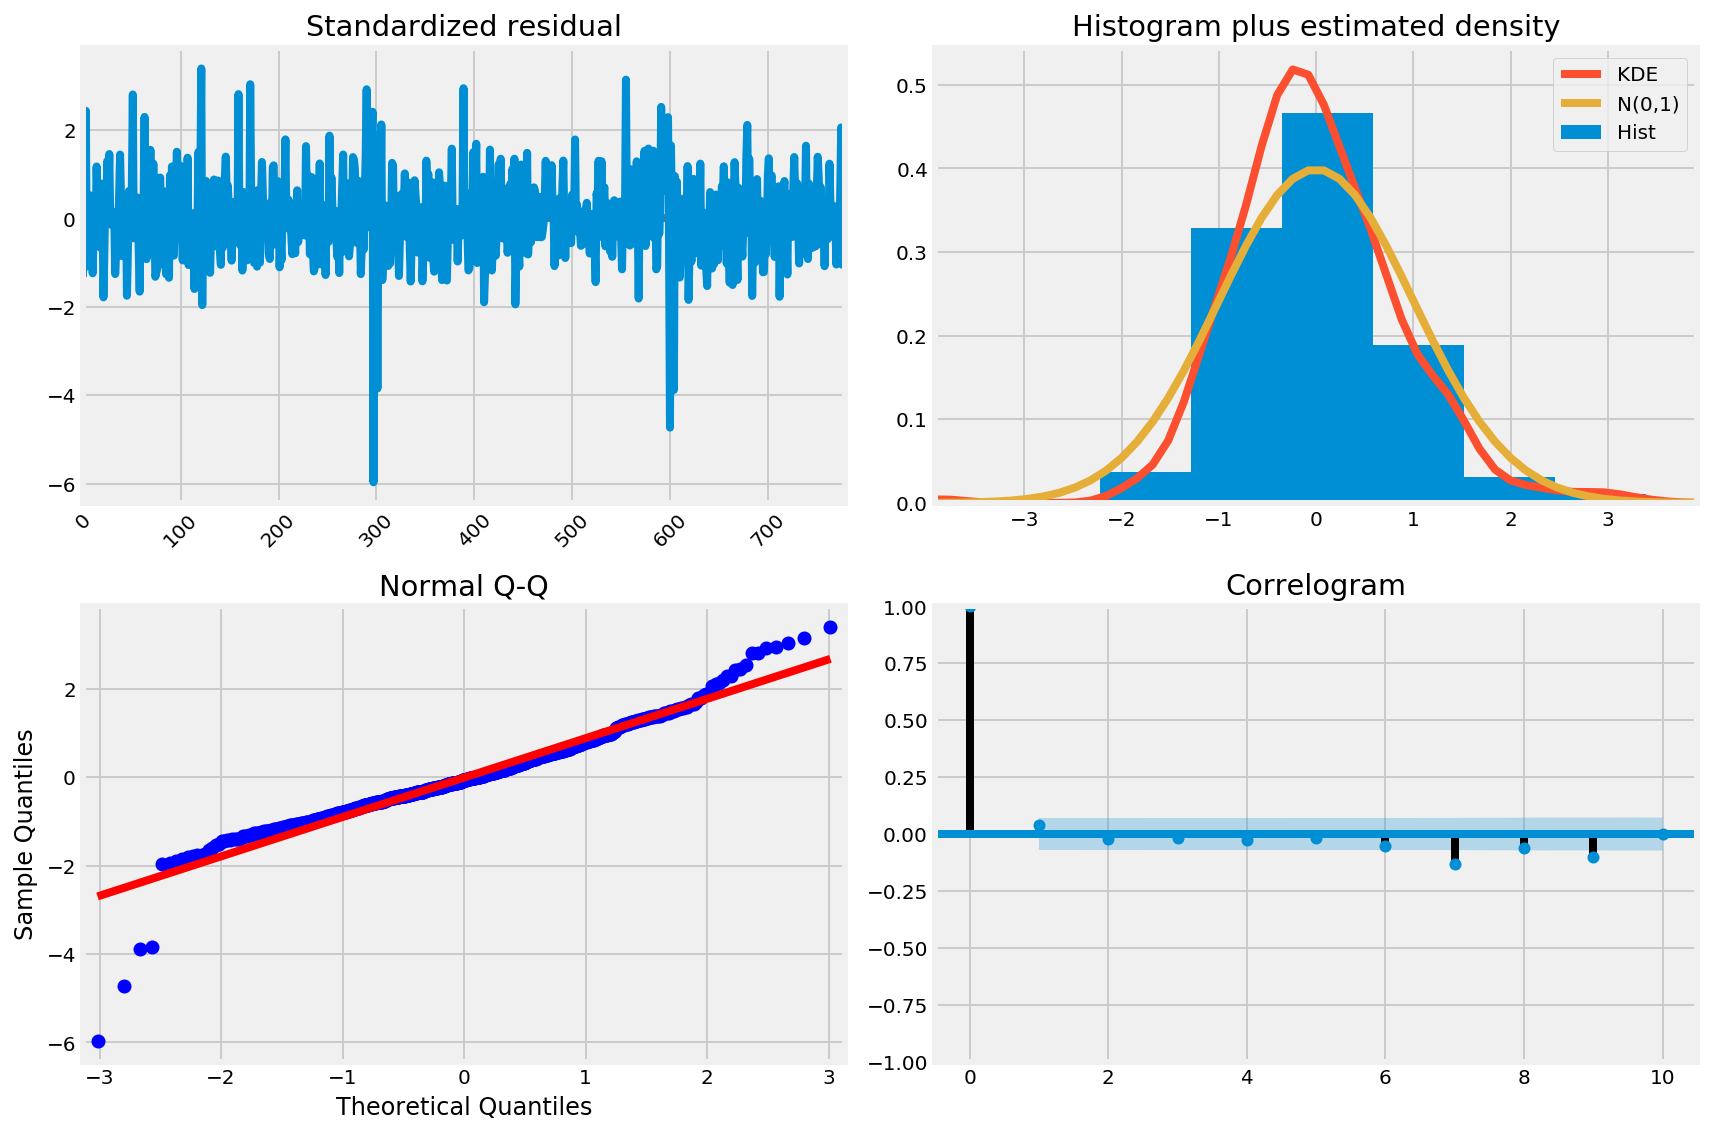

In [49]:
diag_plot = results.plot_diagnostics(0, figsize=(12, 8))
diag_plot.axes[0].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

#### Obtain forecasts

In [50]:
start_p = 60
forecast_end = 20
data = data_cs_diff

preds = results.predict(start=1, end=len(data), dynamic=False)

preds_dyn = results.predict(
    start=1+start_p, end=len(data)+forecast_end, dynamic=True)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [51]:
data.shape, preds_dyn.shape, preds.shape

((780, 2), (740, 2), (780, 2))

In [52]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].plot(data.Sales, 'b--', preds.Sales, 'g-', preds_dyn.Sales, 'r-.')
ax[0].legend(['data', 'non-dynamical forecasting',
              'dynamical forecasting'], loc='lower right')
ax[0].set_title('Sales', fontsize=20)
ax[1].plot(data.Customers, 'b--', preds.Customers, 'g-', preds_dyn.Customers, 'r-.')
ax[1].legend(['data', 'non-dynamical forecasting',
              'dynamical forecasting'], loc='lower right')
ax[1].set_title('Customers', fontsize=20)
plt.show()

ValueError: view limit minimum -36789.450000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

## Resources
---

- [Statsmodels documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.varmax.VARMAX.html)
- [Statsmodels example](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_varmax.html)